## Usando o rENA no python

O exemplo abaixo mostra como utilizar a biblioteca do R rENA com a liguagem python.
Todas as bibliotecas do python podem ser usadas para mnipular e arrumar os dados para serem plotados.

Todas as funçoes da biblioteca podem ser chamadas usando a interface rENA, um outro detalhe ,e que os pontos (.) devem ser substituidos por underscore (_)
Exemplo:
    A função ena.plot() pode ser chamada usando rENA.ena_plot()
    A função ena.plot.points() pode ser chamada usando rENA.ena_plot_points().
    
### Bibliotecas necessárias:
    Devem ser instaladas as bibliotecas R rENA e data.table usando os comandos abaixo:
    install.packages("rENA")
    install.packages("data.table")
    
    No python devemos instalar a biblioteca rpy2 usando o seguinte comando:
    pip install rpy2
    
    

In [44]:
# -*- coding: UTF-8 -*-

from pandas import read_csv, DataFrame
from plotnine import ggplot, geom_point, geom_label, geom_line, aes, stat_smooth, facet_wrap, coord_fixed
from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
pandas2ri.activate()  # makes some conversions automatic

## Importação da biblioteca rENA do R
Suas funções estarão disponíveis na variável "rENA"

In [2]:
rENA = importr('rENA')

## A função robjects possibilita a utilização de funções do R dentro python

In [3]:
#funções do R preparadas para serem chamadas no python
pr = ro.r("print")
colMeans = ro.r("colMeans")
rmax = ro.r("max")

In [4]:
# Leitura dos dados a serem plotados
rsdata = read_csv("/home/jovyan/data/rsdata.csv")

## Identificar colunas para usar no acumulador
Antes de executar a função ena_accumulate_data, precisamos primeiro identificar quais colunas de dados usar em nossas unidades (units), conversas (conversation) e códigos (codes). Há também um parâmetro opcional de metadados (meta), que é para dados específicos da unidade que desejamos realizar no processo de acumulação e nos manter associados às unidades identificadas.

In [5]:
units = rsdata[['Condition','UserName']]
conversation = rsdata[['Condition','GroupName']]
codes = rsdata[['Data','Technical.Constraints','Performance.Parameters','Client.and.Consultant.Requests','Design.Reasoning','Collaboration']]
meta = rsdata[["CONFIDENCE.Change","CONFIDENCE.Pre","CONFIDENCE.Post","C.Change"]]

## Executando a acumulação dos dados
Com os dados identificados e subconjuntos, a acumulação e a geração de conjuntos são bastante simples.

In [6]:
accum = rENA.ena_accumulate_data(units, conversation, codes, meta)

## Gerando o set (confjunto) ENA
A forma mais básica de um ENAset pode ser gerada passando o resultado da chamada da função ena_accumulate_data para ena_make_set.

In [7]:
enaset = rENA.ena_make_set(
  enadata=accum
)

## Plot Units In Each Group

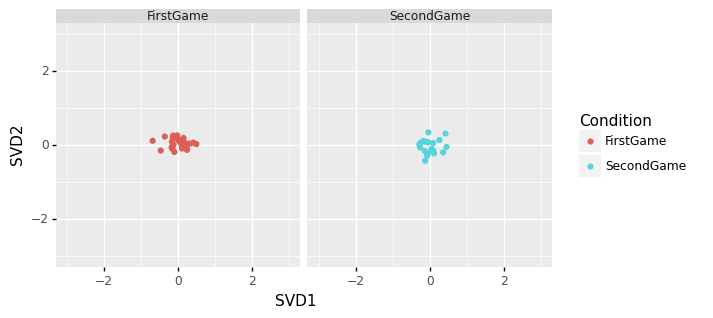

In [52]:
points = enaset.rx2('points')

df_points1 = points.loc[points['Condition'] == "FirstGame"]
df_points2 = points.loc[points['Condition'] == "SecondGame"]
### Subset rotated points for the first condition
first_game_points = df_points1.drop(columns=['ENA_UNIT','Condition','UserName', 'CONFIDENCE.Change', 'CONFIDENCE.Pre', 'CONFIDENCE.Post', "C.Change"])
### Subset rotated points for the second condition
second_game_points = df_points2.drop(columns=['ENA_UNIT','Condition','UserName',  'CONFIDENCE.Change', 'CONFIDENCE.Pre', 'CONFIDENCE.Post', "C.Change"])

plot = ggplot(data=points)
plot += geom_point(mapping=aes(x="SVD1", y="SVD2", color="Condition"))
plot += coord_fixed(ratio=1, xlim=(-3, 3), ylim=(-3, 3))
plot += facet_wrap("Condition")
print(plot)

## Plotting Networks

                             code      SVD1      SVD2      SVD3      SVD4  \
1                            Data  1.662252  0.700171 -0.959910  1.094216   
2           Technical.Constraints -0.109755  1.799084  0.398956 -0.488341   
3          Performance.Parameters  1.177196 -2.052511  0.956132 -0.925879   
4  Client.and.Consultant.Requests -0.495936  0.310701  1.690344  2.428804   
5                Design.Reasoning -2.239086 -0.790025 -1.084363  0.127067   
6                   Collaboration  0.089282  0.649951  1.807759 -1.312459   

       SVD5      SVD6      SVD7      SVD8      SVD9     SVD10     SVD11  \
1  0.524277  0.869807  1.060580  0.284967  0.129718  0.155984 -0.003978   
2 -0.672996 -1.144296 -0.995570 -0.502497 -0.096754 -0.076530 -0.050236   
3 -0.343472 -0.307629 -0.536945 -0.135688 -0.103396 -0.162191 -0.012748   
4  0.126448 -0.740071  0.393789 -0.495162 -0.116266  0.164472 -0.086628   
5  0.307878  0.460038  0.345462  0.350285  0.054655  0.069604  0.077095   
6  0.86681

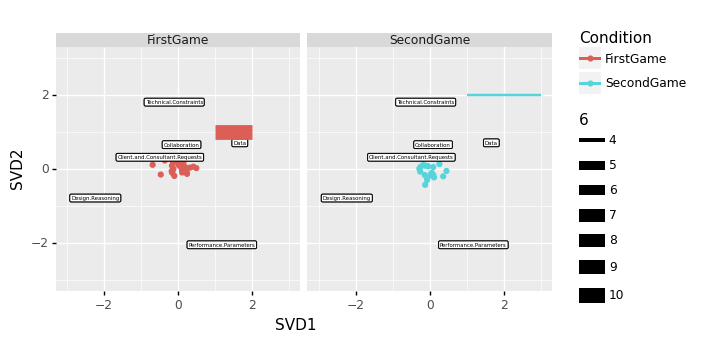

In [54]:
nodes = enaset.rx2("rotation").rx2("nodes")
print(nodes)
plot += geom_point(data=nodes, mapping=aes(x="SVD1", y="SVD2"))
plot += geom_label(data=nodes, mapping=aes(x="SVD1", y="SVD2", label="code", size=6))
xs = [1, 2, 1, 3] # TODO produce these with a smarter loop
ys = [1, 1, 2, 2]
conditions = ["FirstGame", "FirstGame", "SecondGame", "SecondGame"]
sizes = [10, 10, 4, 4]
edges = DataFrame({"x": xs, "y": ys, "Condition": conditions, "size": sizes})
plot += geom_line(data=edges, mapping=aes(x="x", y="y", size="size", color="Condition"))
print(plot)

## Plotting Means

In [9]:
plot = rENA.ena_plot(set, scale_to = [-1, 0, 1], title ="Groups and Means")
plot = rENA.ena_plot_points(plot, points = first_game_points, confidence_interval ="box", colors = ("blue"))
plot = rENA.ena_plot_points(plot, points = second_game_points, confidence_interval ="box", colors = ("red"))
plot = rENA.ena_plot_group(plot, first_game_points, colors = ("red"), confidence_interval ="box")
plot = rENA.ena_plot_group(plot, second_game_points, colors =("blue"), confidence_interval ="box")
pr(plot)

NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'type'>'

## Plotting a Network

In [ ]:
line_weights = (set.rx2('line.weights'))

### Subset lineweights for SecondGame and Calculate the colMeans
first_game_lineweights = line_weights.loc[points['Condition'] == "FirstGame"]
second_game_lineweights = line_weights.loc[points['Condition'] == "SecondGame"]

first_game_lineweights = first_game_lineweights.drop(columns=['ENA_UNIT','Condition','UserName', 'CONFIDENCE.Change', 'CONFIDENCE.Pre', 'CONFIDENCE.Post', "C.Change"])
### Subset rotated points for the second condition
second_game_lineweights = second_game_lineweights.drop(columns=['ENA_UNIT','Condition','UserName',  'CONFIDENCE.Change', 'CONFIDENCE.Pre', 'CONFIDENCE.Post', "C.Change"])

first_game_mean = colMeans(first_game_lineweights)
second_game_mean = colMeans(second_game_lineweights)

subtracted_mean = first_game_mean - second_game_mean

In [ ]:
plot_first = rENA.ena_plot(set, title ="FirstGame")
plot_first = rENA.ena_plot_network(plot_first, network = first_game_mean)
pr(plot_first)

In [ ]:
plot_second = rENA.ena_plot(set, title ="SecondGame")
plot_second = rENA.ena_plot_network(plot_second, network = second_game_mean, colors = ("blue"))
pr(plot_second)

## Plot subtracted network only

In [ ]:
plot_sub = rENA.ena_plot(set, title ="Subtracted")
plot_sub = rENA.ena_plot_network(plot_sub, network = subtracted_mean)
pr(plot_sub)

## Plot Everything Together

In [ ]:
rotation = (set.rx2('rotation'))
nodes = rotation.rx2('nodes')

# Scale the nodes to match that of the network, for better viewing
first_game_points_max = rmax(first_game_points)
second_game_points_max = rmax(second_game_points)
if(first_game_points_max> second_game_points_max):
  point_max = first_game_points_max
else:
  point_max = second_game_points_max

nodes = nodes.drop(columns=['code'])
max_nodes = rmax(nodes)
with localconverter(ro.default_converter + pandas2ri.converter):
  first_game_points = ro.conversion.py2rpy(first_game_points)

first_game_scaled = first_game_points
second_game_scaled = second_game_points

plot = rENA.ena_plot(set, title ="Plot with Units and Network", font_family ="Times")
plot = rENA.ena_plot_points(plot, points = first_game_scaled, colors = ("red"))
plot = rENA.ena_plot_points(plot, points = second_game_scaled, colors = ("blue"))
plot = rENA.ena_plot_group(plot, point = first_game_scaled, colors =("red"), confidence_interval ="box")
plot = rENA.ena_plot_group(plot, point = second_game_scaled, colors =("blue"), confidence_interval ="box")
plot = rENA.ena_plot_network(plot, network = subtracted_mean)
pr(plot)